In [1]:
#from torch.utils.data import *
from sklearn.metrics import roc_curve, auc
from torch.utils.data import ConcatDataset, Dataset, DataLoader, sampler, DistributedSampler

import pyarrow.parquet as pq
import pyarrow as pa # pip install pyarrow==0.7.1
#import ROOT
import numpy as np
np.random.seed(0)
import glob, os

import dask.array as da

#from scipy.misc import imresize

import matplotlib.pyplot as plt
#%matplotlib inline
from matplotlib.colors import LogNorm, ListedColormap, LinearSegmentedColormap
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

from skimage.measure import block_reduce
from numpy.lib.stride_tricks import as_strided
import pandas as pd

from ROOT import TCanvas, TFile, TProfile, TNtuple, TH1F, TH2F
from ROOT import gROOT, gBenchmark, gRandom, gSystem
import ctypes

Welcome to JupyROOT 6.30/04


In [2]:
!pwd

/eos/home-i02/r/rchudasa/SWAN_projects/e2e/MLAnalyzer/plottingMacros


In [3]:
fileStr = '/eos/home-i02/r/rchudasa/SWAN_projects/e2e/MLAnalyzer/convertRootFiles/DYToTauTau_jet.parquet.1'
outDir = '/eos/home-i02/r/rchudasa/SWAN_projects/e2e/MLAnalyzer/plottingMacros/croppedJetIMG_DYTauTau_v2/'
f0s = glob.glob(fileStr)

In [4]:
pf = pq.ParquetFile(fileStr)

In [5]:
pf.num_row_groups

15

In [6]:
df = pd.read_parquet(fileStr)

In [7]:
im = np.array(np.array(np.array(df['X_jet'].tolist()).tolist()).tolist())

In [8]:
im.shape

(15, 13, 125, 125)

In [37]:
#for ch in range(13):
hist_data = im[:,8,:,:]
hist_data = hist_data[hist_data>0.0]

In [38]:
hist_data.shape

(2415,)

In [39]:
h1    = TH1F( 'h1', '', 10, 0, 10 )

Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).


In [40]:
for value in hist_data.flatten():
    h1.Fill(value)

In [41]:
c = TCanvas("myCanvasName","The Canvas Title",800,600)
h1.Draw()



Warning in <TCanvas::Constructor>: Deleting canvas with same name: myCanvasName


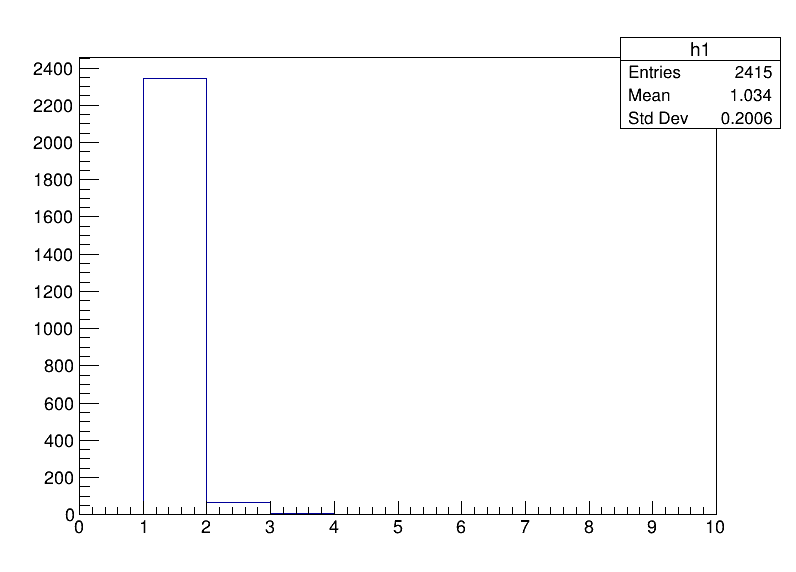

In [42]:
c.Draw()

In [ ]:
check = hist_data>0.0

In [ ]:
check = hist_data[hist_data>0.0]

In [ ]:
max(check)

In [ ]:
if not os.path.exists(outDir):
    print("Experiment Directory not found making one")
    os.makedirs(outDir)

In [ ]:
class ParquetDataset(Dataset):
    def __init__(self, filename):
        self.parquet = pq.ParquetFile(filename)
        self.cols = ['X_jet','y']
        #self.cols = ['X_CMSII']
        #self.cols = ['X_jet.list.item.list.item.list.item','y'] 
    def __getitem__(self, index):
        data = self.parquet.read_row_group(index, columns=self.cols).to_pydict()
        data['X_jet'] = np.float32(data['X_jet'][0])
        #data['X_jet'] = np.float32(data['X_CMSII'][0])
        #data['y'] = np.float32(data['y'])
        #print("index:", index)
        #data['m0'] = np.float32(data['jetM'])
        #data['pt'] = np.float32(data['jetPt'])
        # Preprocessing
        data['X_jet'][data['X_jet'] < 1.e-3] = 0. # Zero-Suppression
        #data['X_jet'][4,...] = 25.*data['X_jet'][4,...] # For HCAL: to match pixel intensity dist of other layers
        #data['X_jet'] = data['X_jet']/100. # To standardize
        return dict(data)
    def __len__(self):
        return self.parquet.num_row_groups

In [ ]:
def custom_div_cmap(numcolors=11, name='custom_div_cmap',mincol='blue', midcol='white', maxcol='red'):
    cmap = LinearSegmentedColormap.from_list(name=name,colors=[mincol, midcol, maxcol],N=numcolors)
    return cmap

pink_map = custom_div_cmap(50, mincol='#FFFFFF', midcol='#F699CD' ,maxcol='#FF1694')

In [ ]:
def plotJet(img, mins, maxs, str_):
    # Create subplots
    fig, ax = plt.subplots()
    mins = 0.0001
    #im = plt.imshow(np.zeros_like(img[8,:,:]), cmap='Purples', vmin=0., vmax=1., alpha=0.9)
    #if maxs[-1] > 0 : plt.imshow(img[8,:,:], cmap='Greens', norm=LogNorm(), alpha=0.9, vmin=mins[-1], vmax=maxs[-1])
    # if maxs[-1] > 0 : plt.imshow(img[7,:,:], cmap='Purples', norm=LogNorm(vmin=mins[-1], vmax=maxs[-1]), alpha=0.9)
    # if maxs[-2] > 0 : plt.imshow(img[6,:,:], cmap='Blues', norm=LogNorm(vmin=mins[-2], vmax=maxs[-2]), alpha=0.9)
    # if maxs[-3] > 0 : plt.imshow(img[5,:,:], cmap='Greens', norm=LogNorm(vmin=mins[-3], vmax=maxs[-3]), alpha=0.9)
    # if maxs[-4] > 0 : plt.imshow(img[4,:,:], cmap='Greys',  norm=LogNorm(vmin=mins[-4], vmax=maxs[-4]), alpha=0.9)
    # if maxs[-5] > 0 : plt.imshow(img[3,:,:], cmap='Blues',  norm=LogNorm(vmin=mins[-5], vmax=maxs[-5]), alpha=0.9)
    # if maxs[-6] > 0 : plt.imshow(img[0,:,:], cmap='Oranges',norm=LogNorm(vmin=mins[-6], vmax=maxs[-6]), alpha=0.9)
    
    zero = ax.imshow(np.zeros_like(img[6,:,:]), cmap='Greys', vmin=0., vmax=1., alpha=0.9)
    hcal = ax.imshow(img[4,:,:],cmap='Greys', norm=LogNorm(vmin=mins, vmax=img[4,:,:].max()), alpha=0.4)
    bpix1 = ax.imshow(img[5,:,:],cmap='Greens', norm=LogNorm(vmin=mins, vmax=img[5,:,:].max()), alpha=0.6)
    bpix2 = ax.imshow(img[6,:,:],cmap='Greens', norm=LogNorm(vmin=mins, vmax=img[6,:,:].max()), alpha=0.6)
    bpix3 = ax.imshow(img[7,:,:],cmap='Greens', norm=LogNorm(vmin=mins, vmax=img[7,:,:].max()), alpha=0.6)
    bpix4 = ax.imshow(img[8,:,:],cmap='Greens', norm=LogNorm(vmin=mins, vmax=img[8,:,:].max()), alpha=0.6)
    strip1 = ax.imshow(img[9,:,:],cmap='Purples', norm=LogNorm(vmin=mins, vmax=img[9,:,:].max()), alpha=0.7)
    strip2 = ax.imshow(img[10,:,:],cmap='Purples', norm=LogNorm(vmin=mins, vmax=img[10,:,:].max()), alpha=0.7)
    strip3 = ax.imshow(img[11,:,:],cmap='Purples', norm=LogNorm(vmin=mins, vmax=img[11,:,:].max()), alpha=0.7)
    strip4 = ax.imshow(img[12,:,:],cmap='Purples', norm=LogNorm(vmin=mins, vmax=img[12,:,:].max()), alpha=0.7)
    tracks = ax.imshow(img[0,:,:],cmap='Oranges',norm=LogNorm(vmin=mins, vmax=img[0,:,:].max()), alpha=0.9)
    ecal = ax.imshow(img[3,:,:],cmap='Blues', norm=LogNorm(vmin=mins, vmax=img[3,:,:].max()), alpha=0.9)

    #plt.colorbar(tracks, ax=ax)

    #X AXIS
#     ax = plt.axes()
    #plt.xlim([0., 125.+0.])
#     plt.xticks(np.arange(0,150,25))
    #ax_range_x = np.arange(0,125+25,25)
    #ax.set_xticks(ax_range_x)
    #ax.set_xticklabels(ax_range_x)
    plt.xlabel(r"$\mathrm{i\varphi}'$", size=28) #28, 30
    ax.xaxis.set_tick_params(direction='in', which='major', length=6.)
    ax.xaxis.set_tick_params(direction='in', which='minor', length=3.)

#     #Y AXIS
    #plt.ylim([125.+0.,0.])
    #plt.yticks(np.arange(150,0,25))
    plt.ylabel(r"$\mathrm{i\eta}'$", size=28) #28, 30
    #ax_range_y = np.arange(0,125+25,25)
    #ax.set_yticks(ax_range_y)
    #ax.set_yticklabels(ax_range_y)
    ax.yaxis.set_tick_params(direction='in', which='major', length=6.)
    ax.yaxis.set_tick_params(direction='in', which='minor', length=3.)

    #LEGEND
    #colors = {1:'tab:orange',2:'tab:blue',3:'tab:grey',4:'tab:green',5:'tab:blue',6:'tab:purple',7:'tab:green'}
    colors = {1:'orange',2:'lightblue',3:'grey',4:'green',5:'Purple'}
    #labels = {1:'Track pT',2:'ECAL',3:'HCAL',4:'PXB1',5:'PXB2',6:'PXB3',7:'PXB4'}
    labels = {1:'Track pT',2:'ECAL',3:'HCAL',4:'Pixel layers',5:'Strip layers'}
    patches =[mpatches.Patch(color=colors[i],label=labels[i]) for i in colors]
    #plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    plt.legend(handles=patches, loc='center left', bbox_to_anchor=(1, 0.5))
#     #plt.savefig(str_, bbox_inches='tight')
    plt.savefig(str_, bbox_inches='tight', format='pdf')
    plt.show()
    #plt.clf()

In [ ]:
def plotJet_chnl(img, cmap_, xmin, xmax, str_):
    fig, ax = plt.subplots()
    ax.imshow(np.zeros_like(img), cmap='Greys', alpha=0.9)
    ax.imshow(img, cmap=cmap_, norm=LogNorm(vmin=xmin, vmax=xmax), alpha=0.9)
    #ax = plt.axes()
    #plt.xlim([0., 125.+0.])
    #ax_range_x = np.arange(0,125+25,25)
    #ax.set_xticks(ax_range_x)
    #ax.set_xticklabels(ax_range_x)
    plt.xlabel(r"$\mathrm{i\varphi}'$", size=28) #28, 30
    ax.xaxis.set_tick_params(direction='in', which='major', length=6.)
    ax.xaxis.set_tick_params(direction='in', which='minor', length=3.)

#     #Y AXIS
    #plt.ylim([125.+0.,0.])
    plt.ylabel(r"$\mathrm{i\eta}'$", size=28) #28, 30
    #ax_range_y = np.arange(0,125+25,25)
    #ax.set_yticks(ax_range_y)
    #ax.set_yticklabels(ax_range_y)
    ax.yaxis.set_tick_params(direction='in', which='major', length=6.)
    ax.yaxis.set_tick_params(direction='in', which='minor', length=3.)
    plt.savefig(str_, bbox_inches='tight', format='pdf')
    plt.clf()
    #plt.show()

In [ ]:
def plotJet_chnl_histogram(img, cmap_, xmin, xmax, str_):
    fig, ax = plt.subplots()
    #ax.imshow(np.zeros_like(img), cmap='Greys', alpha=0.9)
    #ax.imshow(img, cmap=cmap_, norm=LogNorm(vmin=xmin, vmax=xmax), alpha=0.9)
    #ax = plt.axes()
    #plt.xlim([0., 125.+0.])
    #ax_range_x = np.arange(0,125+25,25)
    #ax.set_xticks(ax_range_x)
    #ax.set_xticklabels(ax_range_x)
    plt.hist(img,bins=100)
    plt.xlabel(r"$\mathrm{i\varphi}'$", size=28) #28, 30
    ax.xaxis.set_tick_params(direction='in', which='major', length=6.)
    ax.xaxis.set_tick_params(direction='in', which='minor', length=3.)

#     #Y AXIS
    #plt.ylim([125.+0.,0.])
    plt.ylabel(r"$\mathrm{i\eta}'$", size=28) #28, 30
    #ax_range_y = np.arange(0,125+25,25)
    #ax.set_yticks(ax_range_y)
    #ax.set_yticklabels(ax_range_y)
    ax.yaxis.set_tick_params(direction='in', which='major', length=6.)
    ax.yaxis.set_tick_params(direction='in', which='minor', length=3.)
    plt.savefig(str_, bbox_inches='tight', format='png')
    plt.clf()
    #plt.show()

In [ ]:
dset_train = ParquetDataset(fileStr)
train_cut = 50
idxs = np.random.permutation(len(dset_train))
train_sampler = sampler.SubsetRandomSampler(idxs[:train_cut])
#train_loader = DataLoader(dataset=dset_train, batch_size=32, num_workers=0, sampler=train_sampler, pin_memory=True)
train_loader = DataLoader(dataset=dset_train, batch_size=1, num_workers=0, shuffle=False, pin_memory=True)
counter = 0
for i, data in enumerate(train_loader):
    #if i < args.skipEvents: continue
    #print (" Event ", i)
      
    #if i == args.nEvents: break
    X_train = data['X_jet']
    X_train.shape
    #y_train = data['y']

    #print(type(X_train))
    
    #plt.rcParams["font.family"] = "Helvetica"
    plt.rcParams["figure.figsize"] = (12,12)
    #plt.rcParams["axes.facecolor"] = "white"
    plt.rcParams.update({'font.size': 26})
    
    cmap = ['Oranges','Oranges','Oranges','Blues','Greys','Greens','Greens','Greens','Greens','Purples','Purples','Purples','Purples']
    min_ = 0.0001

    #data['y'][0]
    #print(data['pdgId'])

    print("X_train shape",X_train.shape)
    #nJets = list(data['y'][0].size())[0]
    #nJets = list(data['X_jet'].shape)[0]
    #print("there are ", nJets, "jets in the event")

    #break
    print(nJets)
    for jet in range(nJets):
        img = X_train[jet,:,:,:]
        print("JET LABEL IS  ", jet)
        break
        #Selecting only taus
        #if y_train[jet] == 0: continue
        #histogram = hp.Hist1D(data, bins=30)
        #histogram.plot()
        #plt.hist(img[0,:,:],bins=100,histtype='step')
        #plt.show()

        
        

In [ ]:
pf = pq.ParquetFile(fileStr)

In [ ]:
pf.metadata

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_parquet(fileStr)

In [ ]:
df.columns